In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns

from sklearn                   import metrics, preprocessing
from sklearn.feature_selection import RFECV
from sklearn.model_selection   import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics           import accuracy_score, mean_squared_error, confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn.linear_model      import LogisticRegression
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing     import StandardScaler

In [6]:
finalTeams = pd.read_csv('Season_Stats.csv')
finalTeams = finalTeams.drop(columns = ['Unnamed: 0'])
finalTeams.head()

,Year,Player,Tm,ALL_STAR,Age,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2006.0,Aaron McKie,LAL,No,33.0,14.0,0.0,121.0,6.1,0.272,...,0.500,3.0,17.0,20.0,11.0,5.0,0.0,2.0,7.0,7.0
1,2006.0,Aaron Miles,GSW,No,22.0,19.0,0.0,118.0,6.0,0.405,...,1.000,0.0,14.0,14.0,24.0,4.0,1.0,11.0,13.0,16.0
2,2006.0,Aaron Williams,TOT,No,34.0,48.0,5.0,791.0,11.6,0.551,...,0.690,64.0,117.0,181.0,17.0,17.0,21.0,30.0,138.0,222.0
3,2006.0,Adonal Foyle,GSW,No,30.0,77.0,72.0,1824.0,10.3,0.524,...,0.612,143.0,281.0,424.0,33.0,44.0,125.0,80.0,215.0,345.0
4,2006.0,Adrian Griffin,DAL,No,31.0,52.0,45.0,1245.0,11.6,0.521,...,0.774,75.0,152.0,227.0,89.0,51.0,9.0,39.0,113.0,237.0


In [7]:
# remove outliers by removing players where games < 10
teamsFiltered = finalTeams[finalTeams['G'] >= 10]

#remove outliers by removing players where minutes played <= 50
teamsFiltered = teamsFiltered[teamsFiltered['MP'] >= 200]

In [8]:
teamsFiltered.head()

,Year,Player,Tm,ALL_STAR,Age,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
2,2006.0,Aaron Williams,TOT,No,34.0,48.0,5.0,791.0,11.6,0.551,...,0.690,64.0,117.0,181.0,17.0,17.0,21.0,30.0,138.0,222.0
3,2006.0,Adonal Foyle,GSW,No,30.0,77.0,72.0,1824.0,10.3,0.524,...,0.612,143.0,281.0,424.0,33.0,44.0,125.0,80.0,215.0,345.0
4,2006.0,Adrian Griffin,DAL,No,31.0,52.0,45.0,1245.0,11.6,0.521,...,0.774,75.0,152.0,227.0,89.0,51.0,9.0,39.0,113.0,237.0
5,2006.0,Al Harrington,ATL,No,25.0,76.0,76.0,2782.0,16.0,0.513,...,0.694,132.0,391.0,523.0,238.0,85.0,14.0,195.0,301.0,1411.0
6,2006.0,Al Jefferson,BOS,No,21.0,59.0,7.0,1062.0,16.2,0.530,...,0.642,97.0,202.0,299.0,30.0,30.0,46.0,62.0,166.0,464.0


In [9]:
top_features = ['STL%', 'TOV%', 'USG%', 'OWS', 'WS', 'DBPM', 'BPM', 'VORP', 'STL', 'PF']

In [28]:
mostAllStars = teamsFiltered[(teamsFiltered['ALL_STAR']=='Yes') 
                             & (teamsFiltered['Tm'] != 'TOT')][['Tm','Player']].groupby(['Tm']).count().sort_values(by = 'Player', ascending = False).reset_index()

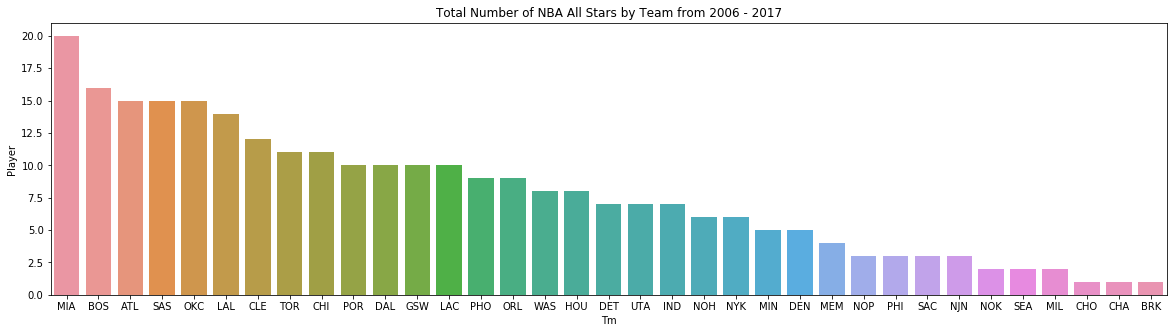

In [11]:
plt.figure(figsize=(20,5))
plt.title('Total Number of NBA All Stars by Team from 2006 - 2017')
sns.barplot(data = mostAllStars, x = 'Tm',y='Player')

In [26]:
teamLocations =  pd.read_csv('teamLocations.csv')
teamLocations = teamLocations[['Team','Lat','Long']]
teamLocations.head()


,Team,Lat,Long
0,MIA,25.761681,-80.191788
1,BOS,42.361145,-71.057083
2,ATL,33.753746,-84.386330
3,SAS,29.424349,-98.491142
4,OKC,35.481918,-97.508469


In [29]:
mostAllStars = mostAllStars.merge(right = teamLocations, left_on = 'Tm', right_on = 'Team')
mostAllStars = mostAllStars[['Tm','Player','Lat','Long']]
mostAllStars.head()

,Tm,Player,Lat,Long
0,MIA,20,25.761681,-80.191788
1,BOS,16,42.361145,-71.057083
2,ATL,15,33.753746,-84.386330
3,SAS,15,29.424349,-98.491142
4,OKC,15,35.481918,-97.508469


In [44]:
import plotly.graph_objects as go

import pandas as pd



mostAllStars['text'] = mostAllStars['Tm'] + '<br>All Star Count ' + (mostAllStars['Player']).astype(str)
# limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
# colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
# cities = []
# scale = 5000

fig = go.Figure()

for i in range(len(mostAllStars['Tm'].unique())):

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = mostAllStars['Long'],
        lat = mostAllStars['Lat'],
        text = mostAllStars['text'],
        marker = dict(
            size = mostAllStars['Player']*10,
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = mostAllStars['Tm'].unique()[i]
    ))

fig.update_layout(
        title_text = 'Total NBA All Stars by Team',
        showlegend = False,
        geo = dict(
            scope = 'usa',
#             landcolor = 'rgb(217, 217, 217)',
        )
    )
fig.show()